In [1]:
"""Sandbox module."""
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import skfda
from scipy.stats import norm

%matplotlib inline

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

In [2]:
def riemann_sum(a, b, m, f, method="left"):
    """Approximate integral."""
    stepsize = (b - a) / m
    if method == "left":
        grid = np.linspace(a, b - stepsize, m)
    elif method == "right":
        grid = np.linspace(a + stepsize, b, m)
    else:
        msg = "Must specify either left or right Riemann sum!"
        raise ValueError(msg)
    return np.sum(f(grid) * stepsize)

In [3]:
# Define normal density
def norm_density(x, mu, sigma):
    """Define normal density function.

    To test: columns of x must align with mu and sigma.
    """
    x = np.array(x)  # to vectorize the input
    mu = np.array(mu)
    sigma = np.array(sigma)
    return np.reciprocal(np.sqrt(2 * np.pi) * sigma) * np.exp(
        (-0.5) * ((x - mu) / sigma) ** 2,
    )


def norm_cdf(x, mu, sigma, m):
    """Compute the CDF of the normal distribution at a given point x."""
    a = -10  # Lower limit of integration (approximation of negative infinity)
    b = x  # Upper limit of integration
    # Integrate the normal density function from a to b
    return riemann_sum(a, b, m, lambda y: norm_density(y, mu, sigma))

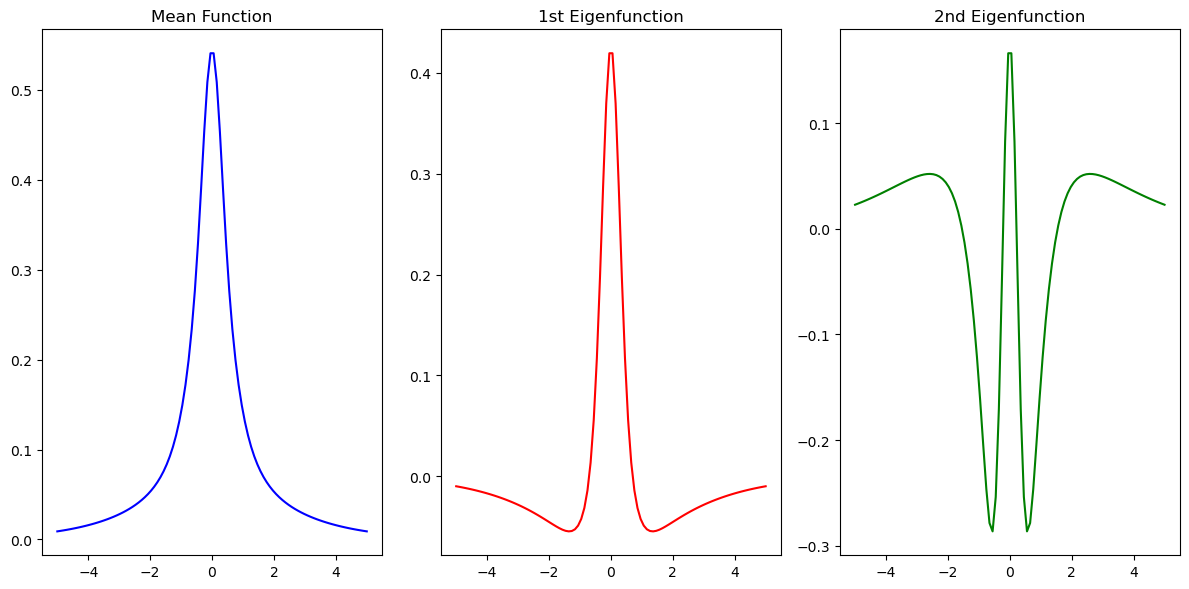

In [13]:
# 1. Generate synthetic functional data
n = 200
gridnum = 100
endpoint_densities = 5
grid_densities = np.linspace(
    start=-np.ones(n) * endpoint_densities,
    stop=np.ones(n) * endpoint_densities,
    num=gridnum,
)
grid_quantiles = np.linspace(
    start=np.ones(n) * 0.01,
    stop=np.ones(n) * 0.99,
    num=gridnum,
)
grid_densities_univ = np.linspace(
    start=-endpoint_densities,
    stop=endpoint_densities,
    num=gridnum,
)
grid_quantiles_univ = np.linspace(start=0, stop=1, num=gridnum)

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)
densities_discretized = norm_density(grid_densities, mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas),
).transpose()

data = densities_discretized

# 2. Compute the mean function
mean_function = np.mean(data, axis=0)

# 3. Center the data
centered_data = data - mean_function

# 4. Estimate the covariance function using a discrete approximation
cov_matrix = np.cov(centered_data, rowvar=False)

# 5. Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenfunctions in decreasing order
eigenvalues_sorted = eigenvalues[np.argsort(-eigenvalues)]
eigenfunctions_sorted = eigenfunctions[:, np.argsort(-eigenvalues)]

# Adjust the lambda function to handle array input and interpolate values from the
# eigenvector

# Compute the L^2 norm for each column (eigenvector) over the domain using riemann_sum
l2_norms_riemann = np.array(
    np.sqrt(
        [
            riemann_sum(
                -1,
                1,
                gridnum,
                lambda x, i=i: np.interp(
                    x,
                    grid_densities_univ,
                    eigenfunctions_sorted[:, i] ** 2,
                ),
            )
            for i in range(gridnum)
        ],
    ),
)

# Scale each column of the eigenfunctions matrix by its respective L^2 norm using
# broadcasting
eigenfunctions_scaled_riemann = eigenfunctions_sorted / l2_norms_riemann

# Check the first few L^2 norms to verify
first_few_norms_riemann = np.array(
    [
        riemann_sum(
            -1,
            1,
            gridnum,
            lambda x, i=i: np.interp(
                x,
                grid_densities_univ,
                eigenfunctions_scaled_riemann[:, i] ** 2,
            ),
        )
        for i in range(5)
    ],
)

# 6. Project the centered data onto the eigenfunctions
fpc_scores_riemann_integral = np.array(
    [
        riemann_sum(
            0,
            1,
            len(grid_densities_univ),
            lambda x, cc=centered_curve, eigfunc=eigenfunction: np.interp(
                x,
                grid_densities_univ,
                cc,
            )
            * np.interp(x, grid_densities_univ, eigfunc),
        )
        for centered_curve in centered_data
        for eigenfunction in eigenfunctions_scaled_riemann.T
    ],
).reshape(n, -1)
fpc_scores = np.dot(centered_data, eigenfunctions_scaled_riemann)

# Plot the mean function and the first two eigenfunctions
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(grid_densities_univ, mean_function, "b-")
plt.title("Mean Function")

plt.subplot(1, 3, 2)
plt.plot(grid_densities_univ, eigenfunctions_sorted[:, 0], "r-")
plt.title("1st Eigenfunction")

plt.subplot(1, 3, 3)
plt.plot(grid_densities_univ, eigenfunctions_sorted[:, 1], "g-")
plt.title("2nd Eigenfunction")

plt.tight_layout()
plt.show()

In [5]:
# Sample densities
partial_vectorized = np.vectorize(partial)
densities = partial_vectorized(norm_density, mu=mus, sigma=sigmas)

## More reproducing of Petersen & Müller (2016)

In [6]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues_sorted[0:k]) / np.sum(eigenvalues_sorted)


fve(2)

0.9761200610430842

In [7]:
def mode_of_variation(alpha, mean_func, eigval, eigfunc):
    """Compute kth mode of variation."""
    return mean_func + alpha * np.sqrt(eigval) * eigfunc

In [8]:
first_mode = mode_of_variation(
    1,
    mean_function,
    eigenvalues_sorted[0],
    eigenfunctions_sorted[:, 0],
)
second_mode = mode_of_variation(
    1,
    mean_function,
    eigenvalues_sorted[1],
    eigenfunctions_sorted[:, 1],
)

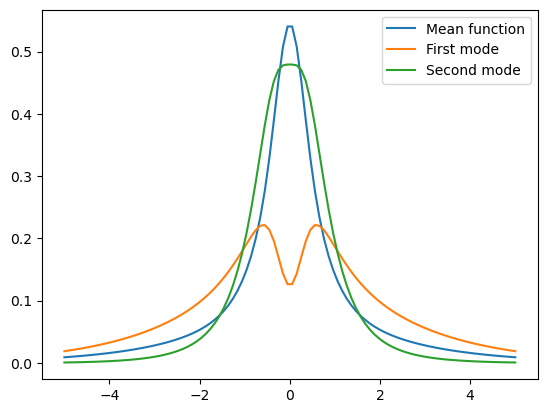

In [9]:
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, mean_function, label="Mean function")
ax.plot(grid_densities_univ, first_mode, label="First mode")
ax.plot(grid_densities_univ, second_mode, label="Second mode")
plt.legend()
plt.show()

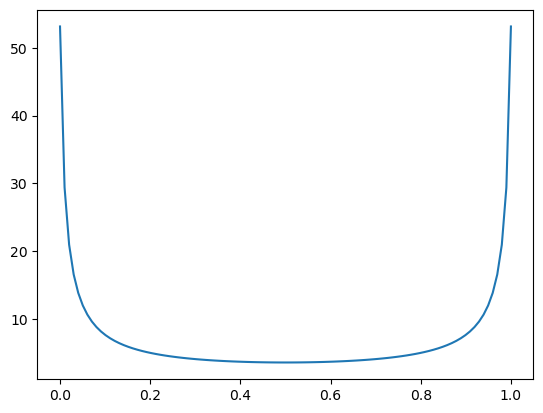

In [10]:
mean_qdf = np.mean(quantile_densities_discretized, axis=0)
plt.plot(grid_quantiles_univ, mean_qdf)

In [11]:
def mean_qdf_interpolator(x):
    """Compute mean_qdf at any point."""
    return np.interp(x, grid_quantiles_univ, mean_qdf)


def wf_mean(x, mu, sigma, m):
    """Wasserstein-Fréchet mean function."""
    return np.reciprocal(mean_qdf_interpolator(norm_cdf(x, mu, sigma, m)))


wf_mean(0, mu=mus[0], sigma=sigmas[0], m=gridnum)

0.2799009692900333

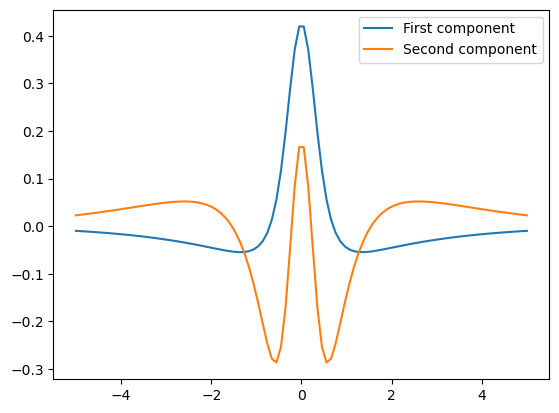

In [16]:
fig, ax = plt.subplots()
# ax.plot(grid_densities_univ, mean_function, label="Mean function")
ax.plot(grid_densities_univ, -eigenfunctions_sorted[:, 0], label="First component")
ax.plot(grid_densities_univ, -eigenfunctions_sorted[:, 1], label="Second component")
plt.legend()
plt.show()